<a href="https://colab.research.google.com/github/leonardofelix346/lia1_2025_2/blob/main/tools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importando o módulo files da biblioteca google.colab
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"leonardo346","key":"abcc38000722b9f8f10f33d2b2c73aa8"}'}

In [ ]:
#configurar o Kaggle no Colab
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install kaggle --quiet


In [ ]:
#baixando e extraindo um dataset do Kaggle
!kaggle datasets download -d salmaneunus/mechanical-tools-dataset
!unzip -q mechanical-tools-dataset.zip -d /content/mechtools



Dataset URL: https://www.kaggle.com/datasets/salmaneunus/mechanical-tools-dataset
License(s): copyright-authors
mechanical-tools-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
replace /content/mechtools/Annotated.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
#verificar se o dataset foi extraído corretamente e se as pastas das classes estão no lugar certo
import os

TRAIN_DIR = '/content/mechtools/train_data_V2'
VAL_DIR   = '/content/mechtools/validation_data_V2'

print("Conteúdo de TRAIN_DIR:", os.listdir(TRAIN_DIR))
print("Conteúdo de VAL_DIR:", os.listdir(VAL_DIR))

Conteúdo de TRAIN_DIR: ['train_data_V2']
Conteúdo de VAL_DIR: ['validation_data_V2']


Conteúdo de BASE_DIR:
['train_data_V2', 'test_data', 'Mechanical Tools Image dataset', 'validation_data_V2', 'Mechanical_Tools_labelled.csv', 'Annotated.csv', 'train_data', 'hammer.csv.csv']

Treino encontrado em: /content/mechtools/train_data/train_data
Validação encontrada em: /content/mechtools/validation_data_V2/validation_data_V2


Carregando hammer: 100%|██████████| 400/400 [00:00<00:00, 459.30it/s]


Classes detectadas: ['Gasoline Can', 'Hammer', 'Pliers', 'Rope', 'Screw Driver', 'Tool box', 'Wrench', 'hammer', 'pebbel', 'screwdriver', 'wrench']
Treino: (5960, 150, 150, 3) Validação: (1200, 150, 150, 3)


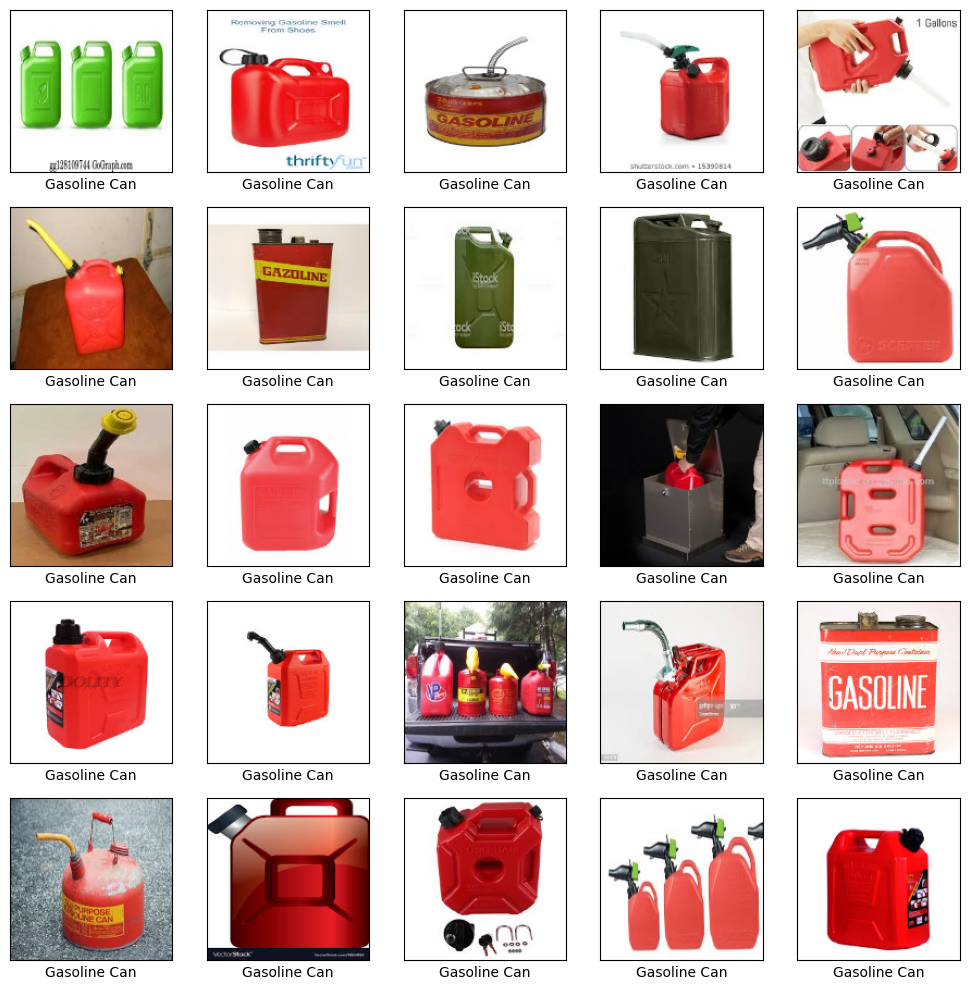

Epoch 1/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 180s 4s/step - accuracy: 0.2255 - loss: 2.3538 - val_accuracy: 0.1425 - val_loss: 2.8775
Epoch 2/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 194s 4s/step - accuracy: 0.4299 - loss: 1.5171 - val_accuracy: 0.0817 - val_loss: 3.7456
Epoch 3/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - accuracy: 0.5225 - loss: 1.3082 - val_accuracy: 0.0133 - val_loss: 4.3025
Epoch 4/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - accuracy: 0.5874 - loss: 1.1494 - val_accuracy: 0.0192 - val_loss: 4.5864
Epoch 5/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 201s 4s/step - accuracy: 0.6802 - loss: 0.9347 - val_accuracy: 0.0283 - val_loss: 4.9082
Epoch 6/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 204s 4s/step - accuracy: 0.7489 - loss: 0.7394 - val_accuracy: 0.0250 - val_loss: 5.1397
Epoch 7/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 165s 4s/step - accuracy: 0.8219 - loss: 0.5862 - val_accuracy: 0.0108 - val_loss: 5.9121
Epoch 8/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - accuracy: 0.8545 - loss: 0.4741 - val_accuracy: 0.

In [ ]:

# Imports

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from google.colab import files
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


# Localizar automaticamente pastas de treino e validação

BASE_DIR = "/content/mechtools"

# Listar tudo dentro da pasta base
print("Conteúdo de BASE_DIR:")
print(os.listdir(BASE_DIR))

# Procurar automaticamente as pastas corretas

def find_dataset_paths(base_dir):
    train_dir, val_dir = None, None
    for root, dirs, files in os.walk(base_dir):
        for d in dirs:
            lower = d.lower()
            if "train" in lower:
                train_dir = os.path.join(root, d)
            elif "val" in lower:
                val_dir = os.path.join(root, d)
    return train_dir, val_dir

TRAIN_DIR, VAL_DIR = find_dataset_paths(BASE_DIR)

print(f"\nTreino encontrado em: {TRAIN_DIR}")
print(f"Validação encontrada em: {VAL_DIR}")

if TRAIN_DIR is None or VAL_DIR is None:
    raise FileNotFoundError("Não foi possível localizar as pastas de treino e validação. Verifique a estrutura do dataset.")


# Função para carregar dataset

IMAGE_SIZE = (150, 150)

def load_data(base_path):
    images, labels = [], []
    class_folders = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]

    for cls in class_folders:
        cls_path = os.path.join(base_path, cls)
        for fname in tqdm(os.listdir(cls_path), desc=f"Carregando {cls}"):
            img_path = os.path.join(cls_path, fname)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, IMAGE_SIZE)
            images.append(img)
            labels.append(cls)

    images = np.array(images, dtype="float32") / 255.0
    unique_classes = sorted(list(set(labels)))
    class_to_idx = {name: i for i, name in enumerate(unique_classes)}
    labels_idx = np.array([class_to_idx[l] for l in labels], dtype="int32")

    return images, labels_idx, unique_classes


# Carregar treino e validação

train_images, train_labels, train_class_names = load_data(TRAIN_DIR)
val_images, val_labels, val_class_names = load_data(VAL_DIR)

# Garantir todas as classes
class_names = sorted(list(set(train_class_names + val_class_names)))
nb_classes = len(class_names)

print("Classes detectadas:", class_names)
print("Treino:", train_images.shape, "Validação:", val_images.shape)


# Função para visualizar imagens do dataset

def visualiza_imagens(images, labels, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.xlabel(class_names[labels[i]])
    plt.tight_layout()
    plt.show()

# Visualizar imagens de treino
visualiza_imagens(train_images, train_labels, class_names)

# Criar modelo CNN

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(150, 150, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(nb_classes, activation="softmax")
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])


# Treinar modelo

history = model.fit(
    train_images, train_labels,
    batch_size=128,
    epochs=20,
    validation_data=(val_images, val_labels)
)


# Avaliação do modelo

val_pred_probs = model.predict(val_images)
val_preds = np.argmax(val_pred_probs, axis=1)

# Matriz de confusão
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

# Relatório de classificação
report = classification_report(val_labels, val_preds, target_names=class_names)
print("Relatório de Classificação:\n")
print(report)


# Função para classificar imagens enviadas pelo usuário

def classify_uploaded_image():
    uploaded = files.upload()
    for filename in uploaded.keys():
        img = cv2.imread(filename)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img_rgb, IMAGE_SIZE)
        img_array = np.expand_dims(img_resized, axis=0) / 255.0

        pred = model.predict(img_array)
        pred_class = class_names[np.argmax(pred)]
        print(f"Classe prevista: {pred_class}")

        plt.imshow(img_rgb)
        plt.title(f"Classe prevista: {pred_class}")
        plt.axis("off")
        plt.show()




Saving Screenshot 2025-09-07 212623.png to Screenshot 2025-09-07 212623.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Classe prevista: wrench


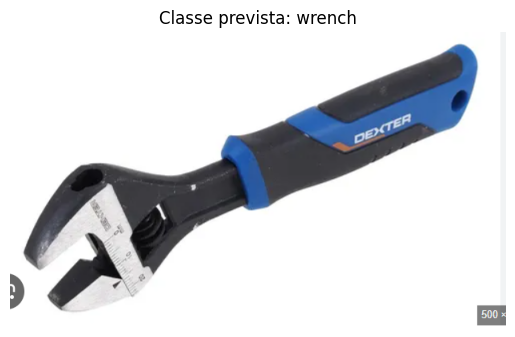

In [ ]:
#Subir imagem para predição
classify_uploaded_image()